# Task 2 - Landsat 8 false color image

## General instructions

First, update the following cell to have a link to your Homework 4 GitHub repository

**UPDATE THIS LINK** https://github.com/a-ramji/eds220-hwk-4

Add comments for all your code and commit as needed. Err on the side of commenting and commiting too much for now.

## Overview
The goal of this task is to create a false color image showing the fire scar of the Thomas fire in 2017. 
Read more about false color images here:
[NASA Earth Observatory - Why is that Forest Red and that Cloud Blue?
How to Interpret a False-Color Satellite Image](https://earthobservatory.nasa.gov/features/FalseColor)

## About the data

In this task you will use two datsets:

**First dataset**

A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. 

Information about Landsat bands from USGS:

- [What are the band designations for the Landsat satellites?](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)

- [Common Landsat Band Combinations](https://www.usgs.gov/media/images/common-landsat-band-combinations)

- [How do I use a scale factor with Landsat Level-2 science products?](https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products)


The data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution ([Landsat Collection in MPC](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)). Data should be used for visualization purposes only. 


**Second dataset**

A shapefile of fire perimeters in California during 2017. 
The [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about).

## File management
All your data files must be  inside a directory named 'data' **in your gitignore**. 

## Data access
All data is in the Canvas-week7-homework zip file.

## FINAL CODE

You will use the next cell at the end of the task. Leave it blank for now.

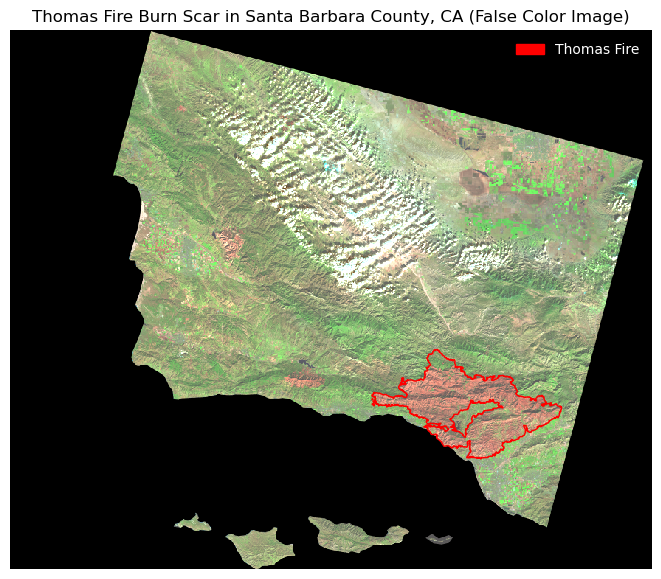

In [1]:
### ===== FINAL CODE =====

# ------Libraries------

# importing libraries with standard abbreviations
# basic libraries
import os # like here() in R
import numpy as np
import pandas as pd

# for spatial/raster data etc. 
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

# for plotting 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends
import matplotlib.lines as mlines # for making our customized marker in the legend
from matplotlib.lines import Line2D  # also for this custom marker 
from matplotlib.markers import MarkerStyle # also for custom markers


from shapely.geometry import Point 
from shapely.geometry import box # for making our bounding box/cropping (optional)

from rasterio.features import rasterize # for rasterizing polygons

pd.set_option('display.max_columns', None) # setting custom full output options for data exploration (optional) 



# ------Importing data------

# 1: importing our LANDSAT data from a NetCDF file in our (semi-reproducible) working directory
# and reading it in/opening it with rioxarray
landsat = rioxr.open_rasterio(os.path.join(os.getcwd(), 'data', 'landsat8-2018-01-26-sb-simplified.nc'))

# 2: importing the CA Fire Perimeters 2017 shapefile from our working directory using geopandas
ca_fires = gpd.read_file(os.path.join(os.getcwd(), 'data', 'California_Fire_Perimeters_2017', 'California_Fire_Perimeters_2017.shp'))



# ------Updating data------

# updating column names: making column names in the California Fire Borders lowercase 
ca_fires.columns = ca_fires.columns.str.lower()

# removing extra/unwanted info: using squeeze() and .drop('band') to remove extra layers from our landsat dataset 
landsat = landsat.squeeze().drop('band')

# reprojecting: ca_fire crs to landsat crs (epsg:32611)
ca_fire_satcrs = ca_fires.to_crs(landsat.rio.crs)


# clipping: clip CA fires to the landsat bounds (optional, helped with processing time)
ca_fires = gpd.clip(ca_fire_satcrs, landsat.rio.bounds())


# filtering: selecting Thomas Fire data by filtering fires data for fire_name == THOMAS
thomas_fire_border = ca_fires.loc[ca_fires.fire_name == "THOMAS"]



# ------Plotting------

# initializing plot using matplotlib
fig, ax = plt.subplots(figsize=(9, 7)) # setting figure size for output

# plotting false color image (without creating any new variables)
landsat[['swir22', # short-wave
         'nir08', # near-infrared
         # and red variables
         'red']].to_array().plot.imshow(robust=True, 
                    # using robust=True argument to deal with cloud RGB values squishing our plot
                                                           ax=ax)


# plotting Thomas fire perimeter using the selection of our ca fires subselection 
# filtered for fire_name == THOMAS
thomas_fire_border.plot(color="none", # empty fill color so we can clearly see the raster data
                   edgecolor="red", # outline color of red for the Thomas Fire
                   # because we're showing perimeter data
                   ax=ax, # sharing same axes
                   )

# updating labels & legend using mpatches.Patch
thomas_fire_border_patch = mpatches.Patch(color='red', # change color to red
                          label='Thomas Fire') # update label

ax.legend(handles = [thomas_fire_border_patch], 
          frameon=False, # removing legend frame
          loc = "upper right", # setting location to upper right-hand side of the plot
          labelcolor = "white") # changing text color so you can see it on the black background

# removing axes
ax.axis('off')

# updating the title
plt.title("Thomas Fire Burn Scar in Santa Barbara County, CA (False Color Image)") 

# displaying plot
plt.show()

## Import libraries and functions

In [2]:
# let's start by importing libraries as usual
import os # like here() in R

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends
import matplotlib.lines as mlines # for making our customized marker in the legend
from matplotlib.lines import Line2D  # also for this custom marker 
from matplotlib.markers import MarkerStyle # also for custom markers
from matplotlib.transforms import Affine2D

#from netcdf4 import Dataset

#import netcdf4

# for spatial/raster data etc. 
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

from shapely.geometry import Polygon # for making our bbox
from shapely.geometry import Point 
from shapely.geometry import box

from rasterio.features import rasterize # for rasterizing polygons
pd.set_option('display.max_columns', None)

## Import data

In [3]:
# 1: importing our LANDSAT data from a NetCDF file in our working directory
landsat_fp = os.path.join(os.getcwd(), 'data', 'landsat8-2018-01-26-sb-simplified.nc')
# reading it in/opening it with rioxarray
landsat = rioxr.open_rasterio(landsat_fp)

# you could also just do this in one line:
# landsat = rioxr.open_rasterio(os.path.join(os.getcwd(), 'data', 'landsat8-2018-01-26-sb-simplified.nc'))

In [4]:
# 2: importing the CA Fire Perimeters 2017 shapefile from our working directory using geopandas
ca_fire = gpd.read_file(os.path.join(os.getcwd(), 'data', 'California_Fire_Perimeters_2017', 'California_Fire_Perimeters_2017.shp'))


## Exploration 

Use the next cell(s) to perform relevant explorations of these datasets.

In [5]:
# exploring landsat: 
landsat.head()

<xarray.Dataset>
Dimensions:      (y: 5, x: 5, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 3.952e+06 3.952e+06 3.951e+06
  * x            (x) float64 1.213e+05 1.216e+05 1.218e+05 1.221e+05 1.224e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...

It looks like the "band" layer is in the third position rather than the 1st... 

In [6]:
# california fire perimeters
ca_fire.head()

,index,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,COMPLEX_IN,IRWINID,FIRE_NUM,DECADES,SHAPE_Leng,SHAPE_Area,geometry
0,19836,41429,2017,CA,CCO,VNC,BROOK,00042450,2017-05-23,2017-05-24,14.0,1.0,1.0,10.043819,per walked track,None,None,None,None,2010,1246.055781,59473.666651,"POLYGON ((-13229812.974 4046876.486, -13229786..."
1,19837,41430,2017,CA,CCO,VNC,PACIFIC,00075307,2017-09-09,2017-09-09,14.0,1.0,1.0,1.190109,Final Walked track. Small spot to the north east,None,None,None,None,2010,561.418202,7081.369481,"POLYGON ((-13286872.985 4074523.355, -13286895..."
2,19838,41431,2017,CA,CCO,VNC,GRADE,00054660,2017-07-04,2017-07-05,14.0,6.0,1.0,47.194027,None,None,None,None,None,2010,2587.259697,279911.825212,"POLYGON ((-13244637.580 4056332.530, -13244620..."
3,19839,41432,2017,CA,CCO,VNC,PACIFICA,00051791,2017-06-24,2017-06-24,14.0,1.0,1.0,1.158548,GPS track,None,None,None,None,2010,501.178102,6859.664843,"POLYGON ((-13229521.754 4046254.111, -13229510..."
4,19840,41433,2017,CA,CCO,VNC,MONTVIEW,00040196,2017-05-15,2017-05-15,14.0,6.0,1.0,2.893327,Rough per description. waiting for walked GPS...,None,None,None,None,2010,484.388887,17133.006159,"POLYGON ((-13229663.036 4046858.853, -13229667..."


In [7]:
# checking crs
print(ca_fire.crs)
print(landsat.rio.crs)

epsg:3857
EPSG:32611


<AxesSubplot:>

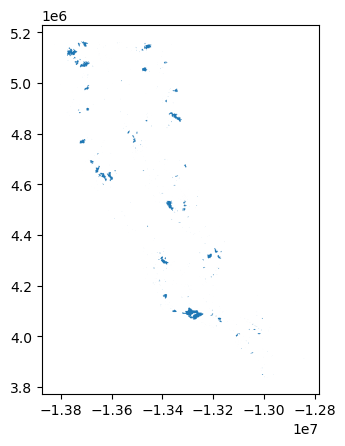

In [8]:
ca_fire.plot()

In [9]:
# exploring some general info about our landsat data
print('height: ', landsat.rio.height)
print('width:', landsat.rio.width)
print('resolution:', landsat.rio.resolution()) # note extra (), method vs. function

print('spatial bounding box: ')
print(landsat.rio.bounds(), '\n')

print('CRS: ', landsat.rio.crs)

height:  731
width: 870
resolution: (270.0, -270.0)
spatial bounding box: 
(121170.0, 3755160.0, 356070.0, 3952530.0) 

CRS:  EPSG:32611


In [10]:
# checking the values of array at the corners with .values
print(type(landsat.values))
landsat.values

<class 'method'>


<bound method Mapping.values of <xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...>

In [11]:
# checking extent of both datasets

print(f"Landsat bounds: {landsat.rio.bounds()}")

print(f"CA Fires bounds: {ca_fire.total_bounds}")
# note: these datasets are currently in different CRSs

Landsat bounds: (121170.0, 3755160.0, 356070.0, 3952530.0)
CA Fires bounds: [-13826421.2614   3838749.5675 -12831475.5712   5164822.2289]


## Updates

If there are any updates needed to the data to plot the true and false color images, perform them in the next cells (you may add as many as you need). 
Comment appropriately.

In [12]:
# first, let's check the CA Fire perimeter column names
ca_fire.columns

Index(['index', 'OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME',
       'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE',
       'GIS_ACRES', 'COMMENTS', 'COMPLEX_NA', 'COMPLEX_IN', 'IRWINID',
       'FIRE_NUM', 'DECADES', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [13]:
# looks like there are no spaces in column names, 
# but the capitalization is inconsistent...

# let's update those!

# making column names lowercase 
ca_fire.columns = ca_fire.columns.str.lower()
print(ca_fire.columns, "\n")

Index(['index', 'objectid', 'year_', 'state', 'agency', 'unit_id', 'fire_name',
       'inc_num', 'alarm_date', 'cont_date', 'cause', 'c_method', 'objective',
       'gis_acres', 'comments', 'complex_na', 'complex_in', 'irwinid',
       'fire_num', 'decades', 'shape_leng', 'shape_area', 'geometry'],
      dtype='object') 



In [14]:
# checking the LANDSAT info (data types & column names)
landsat.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...>

notes:
- our bands named `red`, `green`, and `blue` are named apprpriately/directly
- near-infrared and shortwave infrared are labeled as `nir08` and `swir22`

In [15]:
# the landsat data has extra layers -- let's use squeeze() and drop() 
# to get rid of band and the associated coordinates

# getting rid of band
print(f"Before squeeze:\ndimensions {landsat.dims} \ncoords {landsat.coords} \n")

# using squeeze() and .drop('band') in one line 
landsat = landsat.squeeze().drop('band')

print(f"After squeeze:\ndimensions {landsat.dims}\ncoords: {landsat.coords}")

Before squeeze:
dimensions Frozen({'y': 731, 'x': 870, 'band': 1}) 
coords Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0 

After squeeze:
dimensions Frozen({'y': 731, 'x': 870})
coords: Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0


In [16]:
# checking to make sure that the red, green, blue etc. band info is still preserved as arrays
landsat

<xarray.Dataset>
Dimensions:      (y: 731, x: 870)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0
Data variables:
    red          (y, x) float64 ...
    green        (y, x) float64 ...
    blue         (y, x) float64 ...
    nir08        (y, x) float64 ...
    swir22       (y, x) float64 ...

data variables were preserved!

Next, we'll need to get the CRS of our datasets to match before further analysis


In [17]:
# checking both CRS
print(landsat.rio.crs)
print(ca_fire.crs)

EPSG:32611
epsg:3857


matched crs? True


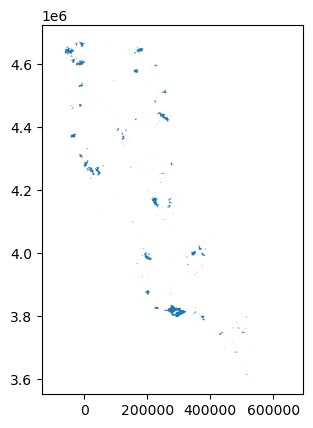

In [18]:
# reprojecting ca_fire crs to landsat crs
ca_fire_satcrs = ca_fire.to_crs(landsat.rio.crs)
ca_fire_satcrs.plot()
print('matched crs?',  ca_fire_satcrs.crs == landsat.rio.crs)

In [19]:
# let's check the extent now that we've updated the crs

print(f"Landsat bounds: {landsat.rio.bounds()}")

print(f"CA Fires bounds: {ca_fire_satcrs.total_bounds}")

ca_fire_satcrs.crs

Landsat bounds: (121170.0, 3755160.0, 356070.0, 3952530.0)
CA Fires bounds: [ -97475.95253218 3603988.08368681  658021.84543093 4671525.78749767]


<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

These bounds/the extent of the datasets are pretty different. Let's crop to the landsat extent before trying to plot. 

<AxesSubplot:>

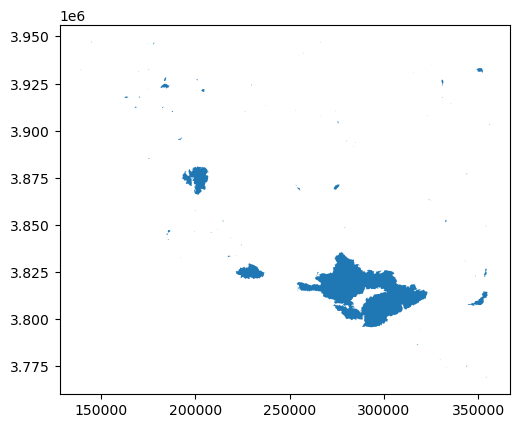

In [20]:
# clipping CA fires to the landsat bounds

ca_fire_small = gpd.clip(ca_fire_satcrs, landsat.rio.bounds())
ca_fire_small.plot()

## True color image

Without creating any new variables:

Select the red, green and blue variables (in that order) of the `xarray.Dataset`, convert it to a `numpy.array` using the `to_array()` method, and then use `.plot.imshow()` to create an RGB image with the data. (There will be a warning)

In [21]:
# selecting red, green, blue variables from landsat dataset
landsat[['red', 'green', 'blue']].to_array()
# checking the "variable" data information to make sure the bands are in the right order

<xarray.DataArray (variable: 3, y: 731, x: 870)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0
  * variable     (variable) <U5 'red' 'green' 'blue'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


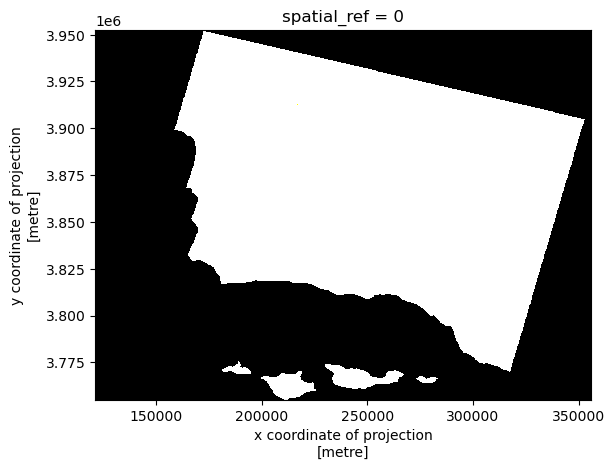

In [22]:
# one-liner
fig, ax = plt.subplots()
landsat[['red', 'green', 'blue']].to_array().plot.imshow(ax=ax)
# the error is letting us know that the data should be clipped to a valid range for imshow with RGB data for floats or for integers
plt.show()

Adjust the scale used for plotting the bands to get a true color image. 
HINT: [Check the `robust` parameter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)
The issue here is the clouds: their RGB values are outliers and cause the other values to be squished when plotting. 

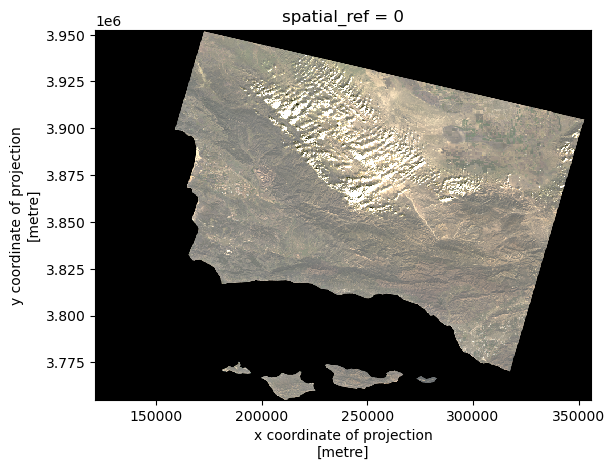

In [23]:
fig, ax = plt.subplots()
# adjusting the scale used for plotting the bands using "robust" parameter
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True, ax=ax)
fig.show()

now this looks more like an actual image of something!

## False color image
Without creating any new variables:

Create a false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables (in that order).

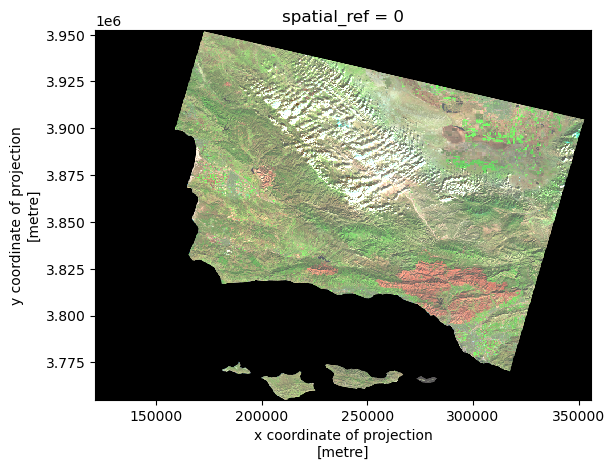

In [24]:
# false color image

# plotting short-wave infrared, near-infrared, and red variables (in that order)
# without creating any new variables
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)

## Updates

If there are any updates needed to the data to create the map, perform them in the next cells (you may add as many as you need). 
Comment appropriately.

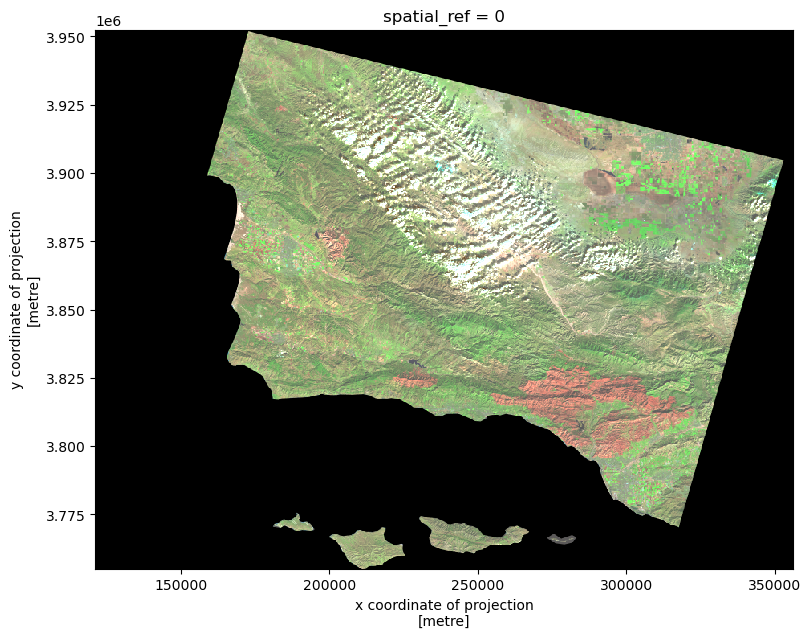

In [25]:

# initializing plot using matplotlib
fig, ax = plt.subplots(figsize=(9, 7)) # setting figure size for output

# plotting false color image using short-wave infrared, near-infrared, and red variables (in that order)
# without creating any new variables
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True, ax=ax)

# displaying plot
plt.show()

## Map

Create a map showing the shortwave infrared/nir/ ed false color image together with the Thomas fire perimeter. 
Customize it appropriately.

## Geographical context of data

- Because we'll be removing the x- and y-axes later on when we make our map, it's important to establish the geographical context of the data. 
- The data displayed in our final map are situated in Santa Barbara County, California (roughly 34.6099° N, 120.0665° W)


<AxesSubplot:>

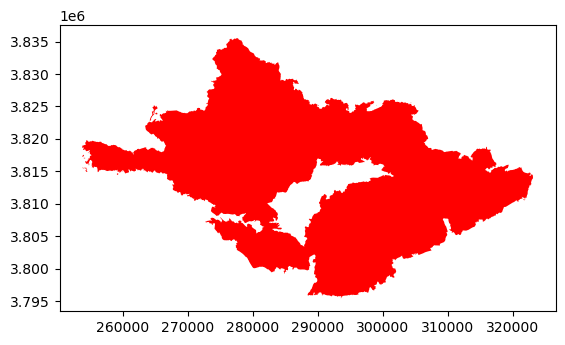

In [26]:
# filtering fires data for fire_name == THOMAS
thomas_fire_border = ca_fire_small.loc[ca_fire_small.fire_name == "THOMAS"]
thomas_fire_border.plot(color="red")

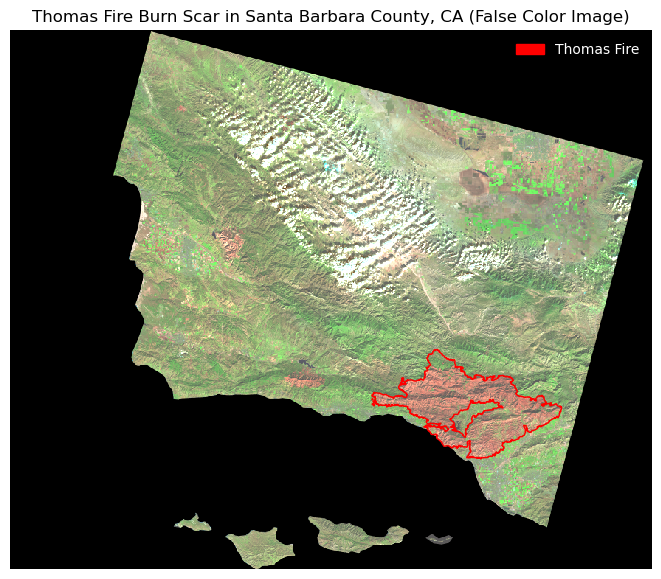

In [27]:
# ---------PLOT-------------

# initializing plot using matplotlib
fig, ax = plt.subplots(figsize=(9, 7)) # setting figure size for output

# plotting false color image (without creating any new variables)
landsat[['swir22', # short-wave
         'nir08', # near-infrared
         # and red variables
         'red']].to_array().plot.imshow(robust=True, 
                    # using robust=True argument to deal with cloud RGB values squishing our plot
                                                           ax=ax)


# plotting Thomas fire perimeter using the selection of our ca fires subselection 
# filtered for fire_name == THOMAS
thomas_fire_border.plot(color="none", # empty fill color
                   edgecolor="red", # outline color of red for the Thomas Fire
                   # because we're showing perimeter data
                   ax=ax, # sharing same axes
                   )

# updating labels & legend using mpatches.Patch
thomas_fire_border_patch = mpatches.Patch(color='red', # change color to red
                          label='Thomas Fire') # update label

ax.legend(handles = [thomas_fire_border_patch], 
          frameon=False, # removing legend frame
          loc = "upper right", # setting location to upper right-hand side of the plot
          labelcolor = "white") # changing text color so you can see it on the black background


# removing axes
ax.axis('off')

# updating the title
plt.title("Thomas Fire Burn Scar in Santa Barbara County, CA (False Color Image)") 


# displaying plot
plt.show()

## Final code

Collect all the relevant code into the first blank cell of the notebook titled "FINAL CODE". This single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The only ouput of this cell should be the plot you produced in the previous exercise. 

Add divisions for relevant sections and comment appropriately.